In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF

# ====================================================================
# KLASS 1: Content-Based Filtering (Innehållsbaserad Filtrering)
# ====================================================================

class ContentBasedRecommender:
    """A content-based recommender system for movies based on genres."""
    def __init__(self, movies_df):
        self.movies_df = movies_df
        self.tfidf_matrix = None
        self.movie_indices = None
    
    def fit(self):
        """Tränar TF-IDF vektoriseringen på genrer."""
        # Fyller saknade värden/ingen genre med tom sträng
        self.movies_df['genres'] = self.movies_df['genres'].fillna('')
        
        # Använder TF-IDF för att omvandla genrer till numeriska vektorer
        tfidf_vectorizer = TfidfVectorizer(stop_words='english')
        self.tfidf_matrix = tfidf_vectorizer.fit_transform(self.movies_df['genres'])
        
        # Skapar en snabb uppslagstabell för filmtitlar till index
        self.movie_indices = pd.Series(self.movies_df.index, index=self.movies_df['title']).drop_duplicates()

    def recommend(self, movie_title, num_recommendations=10):
        """Ger rekommendationer baserat på likhet i genrer (Kosinuslikhet)."""
        if movie_title not in self.movie_indices:
            print(f"Filmen '{movie_title}' hittades inte.")
            return []
            
        movie_index = self.movie_indices[movie_title]
        movie_vector = self.tfidf_matrix[movie_index]
        
        # Beräknar Kosinuslikhet mellan den valda filmen och alla andra filmer
        similarity_scores = cosine_similarity(movie_vector, self.tfidf_matrix).flatten()
        
        movie_similarity_list = list(enumerate(similarity_scores))
        
        # Sortera filmer baserat på likhetspoängen, i fallande ordning
        sorted_similar_movies = sorted(movie_similarity_list, key=lambda x: x[1], reverse=True)
        
        # Väljer de N bästa rekommendationerna (exklusive sig själv - därav index 1)
        top_movie_indices = [i[0] for i in sorted_similar_movies[1:num_recommendations + 1]]
        
        return self.movies_df['title'].iloc[top_movie_indices].tolist()

# ====================================================================
# KLASS 2: Hybrid Recommender (Kollaborativ & Innehållsbaserad)
# ====================================================================

class HybridRecommender:
    def __init__(self, movie_data_path, rating_data_path):
        # Läs in dataset (Antar MovieLens-format)
        self.movies_df = pd.read_csv(movie_data_path)
        self.ratings_df = pd.read_csv(rating_data_path)
        
        # Instansiera Content-Based Recommender
        self.content_recommender = ContentBasedRecommender(self.movies_df)
        
        # Attribut för Collaborative Filtering (NMF)
        self.nmf_model = None
        self.user_item_matrix = None
        self.user_mapper = None
        self.movie_mapper = None
        self.Q = None # User factors matrix
        self.P = None # Item factors matrix

    def fit(self):
        """Tränar både den innehållsbaserade och den kollaborativa modellen."""
        print("1. Fitting content-based model...")
        self.content_recommender.fit()
        print(" Content-based model fitted.")

        # --- Collaborative Filtering (NMF) Fit-steg ---
        print("\n2. Fitting collaborative filtering model (NMF)...")
        
        # Filtrering för hanterbarhet: Hantera en stor datamängd (25M)
        # För att minska matrisens storlek och gleshet.
        
        # Filtrera bort filmer med färre än 100 betyg
        min_movie_ratings = 100
        movie_counts = self.ratings_df.groupby('movieId')['rating'].count()
        popular_movies = movie_counts[movie_counts >= min_movie_ratings].index
        filtered_ratings_df = self.ratings_df[self.ratings_df['movieId'].isin(popular_movies)]

        # Filtrera bort användare med färre än 50 betyg
        min_user_ratings = 50
        user_counts = filtered_ratings_df.groupby('userId')['rating'].count()
        active_users = user_counts[user_counts >= min_user_ratings].index
        filtered_ratings_df = filtered_ratings_df[filtered_ratings_df['userId'].isin(active_users)]
        
        print(f"   Antal betyg efter filtrering: {filtered_ratings_df.shape[0]}")
        print(f"   Antal aktiva användare: {filtered_ratings_df['userId'].nunique()}")
        print(f"   Antal populära filmer: {filtered_ratings_df['movieId'].nunique()}")

        # Skapa Användar-Artikel-Matris (User-Item Matrix)
        self.user_item_matrix = filtered_ratings_df.pivot_table(
            index='userId', 
            columns='movieId', 
            values='rating'
        ).fillna(0) # Fyller saknade betyg (ej betygsatta) med 0

        # Skapa mappers (för att konvertera interna index till externa ID:n)
        self.user_mapper = {id: i for i, id in enumerate(self.user_item_matrix.index)}
        self.movie_mapper = {id: i for i, id in enumerate(self.user_item_matrix.columns)}

        # Träna NMF-modellen
        N_COMPONENTS = 20 # Antal latenta faktorer (ett hyperparameter)
        self.nmf_model = NMF(n_components=N_COMPONENTS, 
                             init='random', 
                             random_state=42, 
                             max_iter=300, 
                             tol=0.001)
        
        # NMF dekomponerar matrisen R till Q och P
        # Q (User Matrix): Användarpreferenser (User x Factors)
        self.Q = self.nmf_model.fit_transform(self.user_item_matrix)
        
        # P (Item Matrix): Filmfaktorer (Factors x Item)
        self.P = self.nmf_model.components_

        print(" Collaborative filtering model fitted.")


    def recommend(self, user_id, movie_title_seed, num_recommendations=10):
        """
        Genererar hybridrekommendationer.
        Strategi: Tar de bästa Collaborative-rekommendationerna för användaren
                  och lägger till Content-based rekommendationer baserat på en 'seed-film'.
        """
        if self.nmf_model is None:
            print("Modellen har inte tränats. Vänligen anropa 'fit' metoden först.")
            return []

        print(f"\n--- Genererar Rekommendationer för Användare {user_id} ---")
        
        # 1. Content-based rekommendationer (från seed-film)
        content_recs = self.content_recommender.recommend(movie_title_seed, num_recommendations)
        print(f"Content-Based baserat på '{movie_title_seed}': {content_recs}")
        
        
        # 2. Collaborative Filtering rekommendationer (från NMF)
        if user_id not in self.user_mapper:
            print(f"Användare {user_id} saknas i NMF-modellen (Cold Start).")
            # Returnerar endast content-based som en fallback för Cold Start-fall
            return content_recs

        user_index = self.user_mapper[user_id]
        
        # Förutsäg matrisen: R_pred = Q * P. Vi behöver bara raden för vår användare.
        predicted_ratings = self.Q[user_index, :] @ self.P
        predicted_ratings_series = pd.Series(predicted_ratings, index=self.user_item_matrix.columns)
        
        # Filtrera bort filmer som användaren redan har sett/betygsatt (> 0)
        user_row = self.user_item_matrix.loc[user_id]
        rated_movie_ids = user_row[user_row > 0].index
        unrated_predictions = predicted_ratings_series[~predicted_ratings_series.index.isin(rated_movie_ids)]
        
        # Hämta de N filmerna med högst förutsagda betyg
        top_collab_movie_ids = unrated_predictions.nlargest(num_recommendations).index.tolist()
        
        # Mappa movieId till titlar
        collaborative_recs = self.movies_df[self.movies_df['movieId'].isin(top_collab_movie_ids)]['title'].tolist()
        print(f"Collaborative Filtering (NMF) rekommendationer: {collaborative_recs}")

        
        # 3. Hybrid Strategi: Kombinera och deduplicera
        # Vi kombinerar resultaten, prioriterar de kollaborativa för den specifika användaren,
        # men inkluderar innehållsbaserade som en breddning (ser till att de är unika).
        
        hybrid_recs_set = set(collaborative_recs)
        final_hybrid_list = collaborative_recs
        
        # Lägg till content-recs om de inte redan finns
        for movie in content_recs:
            if movie not in hybrid_recs_set:
                final_hybrid_list.append(movie)
            
        return final_hybrid_list[:num_recommendations]


# ====================================================================
# EXEMPEL PÅ ANVÄNDNING (Körning)
# ====================================================================

if __name__ == '__main__':
    
    # OBS: ÄNDRA DESSA SÖKVÄGAR OM FILERNA LIGGER PÅ ETT ANNAT STÄLLE
    MOVIE_DATA_PATH = 'movies.csv'
    RATING_DATA_PATH = 'ratings.csv'

    try:
        # 1. Initialisera och Träna Modellen
        hybrid_recommender = HybridRecommender(MOVIE_DATA_PATH, RATING_DATA_PATH)
        hybrid_recommender.fit()
        
        # 2. Välj en användare och en seed-film för rekommendation
        # Välj en användare som är känd/aktiv i vårt filtrerade dataset. userId=1 är en bra startpunkt.
        TEST_USER_ID = 1
        # Välj en populär film som seed för Content-Based delen
        SEED_MOVIE_TITLE = 'Toy Story (1995)' 
        NUM_RECS = 10

        # 3. Generera Hybrid Rekommendationer
        recommendations = hybrid_recommender.recommend(TEST_USER_ID, SEED_MOVIE_TITLE, NUM_RECS)
        
        print("\n==============================================")
        print(f"SLUTLIGA HYBRID REKOMMENDATIONER för Användare {TEST_USER_ID}:")
        for i, title in enumerate(recommendations):
            print(f"{i+1}. {title}")
        print("==============================================")

    except FileNotFoundError:
        print("\nFEL: Kunde inte hitta 'movies.csv' eller 'ratings.csv'.")
        print("Se till att filerna ligger i samma mapp eller uppdatera sökvägarna i koden.")
    except Exception as e:
        print(f"\nEtt fel uppstod under körning: {e}")

1. Fitting content-based model...
 Content-based model fitted.

2. Fitting collaborative filtering model (NMF)...
   Antal betyg efter filtrering: 22546444
   Antal aktiva användare: 102149
   Antal populära filmer: 10326
 Collaborative filtering model fitted.

--- Genererar Rekommendationer för Användare 1 ---
Content-Based baserat på 'Toy Story (1995)': ['Antz (1998)', 'Toy Story 2 (1999)', 'Adventures of Rocky and Bullwinkle, The (2000)', "Emperor's New Groove, The (2000)", 'Monsters, Inc. (2001)', 'Wild, The (2006)', 'Shrek the Third (2007)', 'Tale of Despereaux, The (2008)', 'Asterix and the Vikings (Astérix et les Vikings) (2006)', 'Turbo (2013)']
Collaborative Filtering (NMF) rekommendationer: ['Trainspotting (1996)', 'Clockwork Orange, A (1971)', 'Being John Malkovich (1999)', 'Memento (2000)', 'Mulholland Drive (2001)', 'Donnie Darko (2001)', 'Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Spirited Away (Sen to Chihiro no kamikakushi) (2001)', 'Kill Bill: Vol. 1 

Datainläsning lyckades.

STEG 1: Exploratory Data Analysis (EDA)

--- Movies DataFrame (Huvuddatan) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB

--- Ratings DataFrame (Betygsdata) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB

--- Top 10 Genrer ---
Drama        4361
Comedy       3756
Thriller     1894
Action       1828
Romance      1596
Adventure    1263
Crime        1199
Sci-Fi        980
Horror        978
Fantasy       779


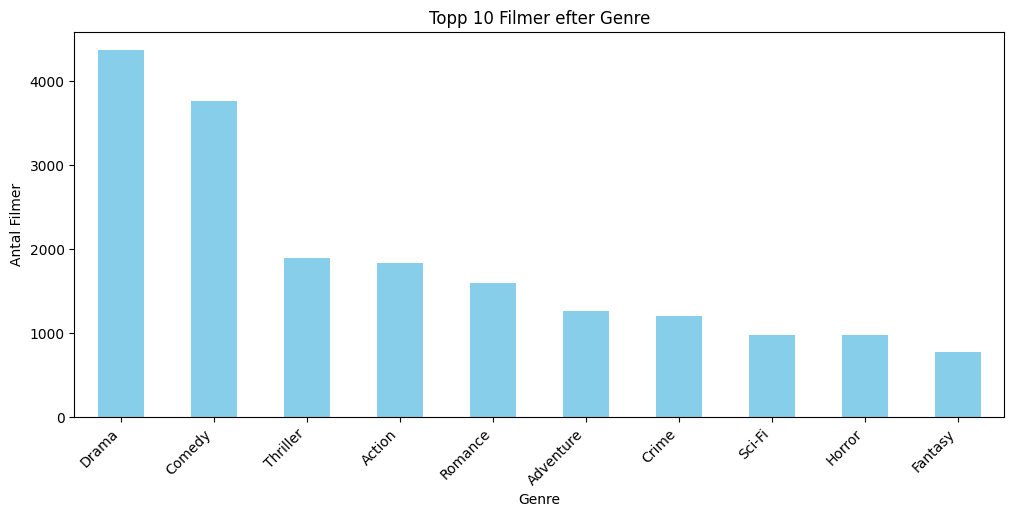


--- Betygsstatistik ---
count    2.500010e+07
mean     3.533854e+00
std      1.060744e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


C:\Users\jeren\AppData\Local\Temp\ipykernel_11072\893650667.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings_df, palette='viridis')


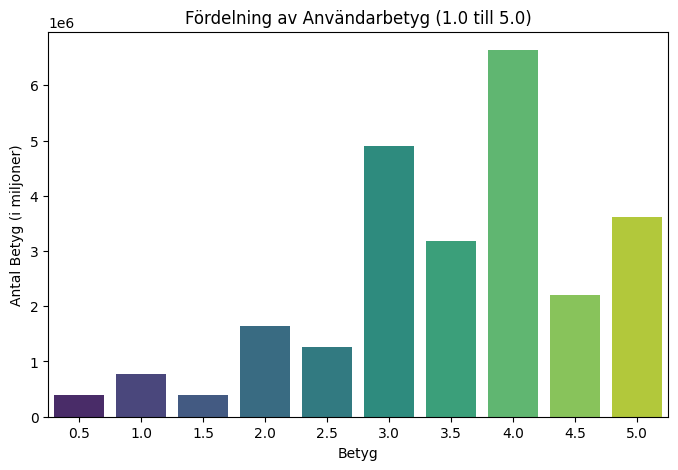


--- Aktivitetsstatistik och Gleshet ---
Antal unika Användare: 162,541
Antal unika Filmer som betygsatts: 59,047
Totalt antal betyg: 25,000,095
Matrisens Gleshet (Sparsity): 0.9974 (Extremt gles!)

STEG 2: Träning av Rekommendationsmodeller
1. Fitting content-based model...
   ✅ Content-based model fitted.
2. Fitting collaborative filtering model (NMF)...
   Filtrerat: 22,546,444 betyg, 102149 användare, 10326 filmer.


c:\Users\jeren\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\decomposition\_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


    Collaborative filtering model fitted (NMF).

STEG 3: Jämförelse av Rekommendationssystem för Användare 1

--- A. Collaborative Filtering (NMF) ---
1. Trainspotting (1996)
2. Clockwork Orange, A (1971)
3. Being John Malkovich (1999)
4. Memento (2000)
5. Donnie Darko (2001)
6. Lord of the Rings: The Fellowship of the Ring, The (2001)
7. Spirited Away (Sen to Chihiro no kamikakushi) (2001)
8. Kill Bill: Vol. 1 (2003)
9. Lord of the Rings: The Return of the King, The (2003)
10. Kill Bill: Vol. 2 (2004)

--- B. Content-Based Filtering (User-Item) ---
1. Heat (1995)
2. Assassins (1995)
3. Nick of Time (1995)
4. Jade (1995)
5. Die Hard: With a Vengeance (1995)
6. Net, The (1995)
7. Safe (1995)
8. Drop Zone (1994)
9. Hideaway (1995)
10. Natural Born Killers (1994)

--- C. Hybrid Blending (Alpha=0.7) ---
1. Trainspotting (1996)
2. Clockwork Orange, A (1971)
3. Big Lebowski, The (1998)
4. Fight Club (1999)
5. Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)
6. Memento (2000)
7. Donnie

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import seaborn as sns

# ====================================================================
# STEG 0: Datainläsning och Konstanter
# ====================================================================

# Konstanter för sökvägar (Justera vid behov)
MOVIE_DATA_PATH = 'movies.csv'
RATING_DATA_PATH = 'ratings.csv'

try:
    movies_df = pd.read_csv(MOVIE_DATA_PATH)
    ratings_df = pd.read_csv(RATING_DATA_PATH)
    print("Datainläsning lyckades.")
except FileNotFoundError:
    print("FEL: Kunde inte hitta 'movies.csv' eller 'ratings.csv'. Se till att filerna ligger i samma mapp.")
    exit()

# ====================================================================
# STEG 1: Exploratory Data Analysis (EDA)
# ====================================================================

print("\n" + "="*50)
print("STEG 1: Exploratory Data Analysis (EDA)")
print("="*50)

# 1.1 Datasetöversikt
print("\n--- Movies DataFrame (Huvuddatan) ---")
movies_df.info()
print("\n--- Ratings DataFrame (Betygsdata) ---")
ratings_df.info()

# 1.2 Genreräkning (För Content-Based)
print("\n--- Top 10 Genrer ---")
genre_counts = movies_df['genres'].str.split('|', expand=True).stack().value_counts()
print(genre_counts.head(10))

# Visualisering av genrer
plt.figure(figsize=(12, 5))
genre_counts.head(10).plot(kind='bar', color='skyblue')
plt.title('Topp 10 Filmer efter Genre')
plt.ylabel('Antal Filmer')
plt.xlabel('Genre')
plt.xticks(rotation=45, ha='right')
plt.show()

# 1.3 Betygsfördelning (För Collaborative Filtering)
print("\n--- Betygsstatistik ---")
print(ratings_df['rating'].describe())

# Visualisering av betyg
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=ratings_df, palette='viridis')
plt.title('Fördelning av Användarbetyg (1.0 till 5.0)')
plt.xlabel('Betyg')
plt.ylabel('Antal Betyg (i miljoner)')
plt.show()

# 1.4 Aktivitet och Gleshet (Sparsity)
num_users = ratings_df['userId'].nunique()
num_movies_rated = ratings_df['movieId'].nunique()
num_total_ratings = ratings_df.shape[0]
possible_ratings = num_users * num_movies_rated
sparsity = 1 - (num_total_ratings / possible_ratings)

print("\n--- Aktivitetsstatistik och Gleshet ---")
print(f"Antal unika Användare: {num_users:,}")
print(f"Antal unika Filmer som betygsatts: {num_movies_rated:,}")
print(f"Totalt antal betyg: {num_total_ratings:,}")
print(f"Matrisens Gleshet (Sparsity): {sparsity:.4f} (Extremt gles!)")


# ====================================================================
# KLASS 2: Content-Based Filtering (Item-Item Similarity)
# ====================================================================

class ContentBasedRecommender:
    """A content-based recommender system for movies based on genres."""
    def __init__(self, movies_df):
        self.movies_df = movies_df
        self.tfidf_matrix = None
        self.movie_indices = None
    
    def fit(self):
        self.movies_df['genres'] = self.movies_df['genres'].fillna('')
        tfidf_vectorizer = TfidfVectorizer(stop_words='english')
        self.tfidf_matrix = tfidf_vectorizer.fit_transform(self.movies_df['genres'])
        self.movie_indices = pd.Series(self.movies_df.index, index=self.movies_df['title']).drop_duplicates()

    def recommend(self, movie_title, num_recommendations=10):
        if movie_title not in self.movie_indices: return []
        movie_index = self.movie_indices[movie_title]
        movie_vector = self.tfidf_matrix[movie_index]
        similarity_scores = cosine_similarity(movie_vector, self.tfidf_matrix).flatten()
        movie_similarity_list = list(enumerate(similarity_scores))
        sorted_similar_movies = sorted(movie_similarity_list, key=lambda x: x[1], reverse=True)
        top_movie_indices = [i[0] for i in sorted_similar_movies[1:num_recommendations + 1]]
        return self.movies_df['title'].iloc[top_movie_indices].tolist()

    def get_tfidf_matrix(self):
        """Hjälpmetod för hybridmodellen."""
        return self.tfidf_matrix

# ====================================================================
# KLASS 3: Hybrid Recommender (NMF Collaborative + Weighted Content)
# ====================================================================

class HybridRecommender:
    def __init__(self, movie_data_path, rating_data_path):
        self.movies_df = pd.read_csv(movie_data_path)
        self.ratings_df = pd.read_csv(rating_data_path)
        self.content_recommender = ContentBasedRecommender(self.movies_df)
        
        self.nmf_model = None
        self.user_item_matrix = None
        self.user_mapper = None
        self.movie_mapper = None
        self.Q = None
        self.P = None
        
    def _get_content_rating_prediction(self, user_id, movie_id):
        """Beräknar ett Content-Based förväntat betyg (User-Item Prediction)."""
        
        # 1. Hämta index för den osett filmen (i)
        movie_row = self.movies_df[self.movies_df['movieId'] == movie_id]
        if movie_row.empty: return 0
            
        i_index = movie_row.index[0]
        i_vector = self.content_recommender.get_tfidf_matrix()[i_index]

        # 2. Hämta användarens historiska betyg (I_u)
        user_ratings = self.ratings_df[self.ratings_df['userId'] == user_id]
        if user_ratings.empty: return 0

        # 3. Hämta index och betyg för filmer användaren har betygsatt
        rated_movie_ids = user_ratings['movieId'].tolist()
        
        # Filtrera endast filmer som finns i movies_df (viktigt)
        rated_df = self.movies_df[self.movies_df['movieId'].isin(rated_movie_ids)]
        rated_movie_indices = rated_df.index.tolist()
        
        if not rated_movie_indices: return 0

        # Hämta TF-IDF-vektorerna och betyg för de betygsatta filmerna
        rated_vectors = self.content_recommender.get_tfidf_matrix()[rated_movie_indices]
        
        ratings_map = user_ratings.set_index('movieId')['rating'].to_dict()
        actual_ratings = np.array([ratings_map[self.movies_df.iloc[idx]['movieId']] for idx in rated_movie_indices])

        # 4. Beräkna likhet (sim(i, j)) och viktat medelvärde
        similarity_scores = cosine_similarity(i_vector, rated_vectors).flatten()
        
        weighted_sum = np.sum(similarity_scores * actual_ratings)
        sum_of_weights = np.sum(similarity_scores)

        return weighted_sum / sum_of_weights if sum_of_weights > 0 else 0


    def fit(self):
        print("\n" + "="*50)
        print("STEG 2: Träning av Rekommendationsmodeller")
        print("="*50)

        # Content-Based (TF-IDF på genrer)
        print("1. Fitting content-based model...")
        self.content_recommender.fit()
        print("    Content-based model fitted.")

        # Collaborative Filtering (NMF)
        print("2. Fitting collaborative filtering model (NMF)...")
        
        # --- Filtrering för hanterbarhet (NMF) ---
        MIN_MOVIE_RATINGS = 100
        MIN_USER_RATINGS = 50
        
        # Filtrera icke-populära filmer och inaktiva användare
        movie_counts = self.ratings_df.groupby('movieId')['rating'].count()
        popular_movies = movie_counts[movie_counts >= MIN_MOVIE_RATINGS].index
        filtered_ratings_df = self.ratings_df[self.ratings_df['movieId'].isin(popular_movies)]

        user_counts = filtered_ratings_df.groupby('userId')['rating'].count()
        active_users = user_counts[user_counts >= MIN_USER_RATINGS].index
        filtered_ratings_df = filtered_ratings_df[filtered_ratings_df['userId'].isin(active_users)]
        
        print(f"   Filtrerat: {filtered_ratings_df.shape[0]:,} betyg, {filtered_ratings_df['userId'].nunique()} användare, {filtered_ratings_df['movieId'].nunique()} filmer.")

        # Skapa Användar-Artikel-Matris
        self.user_item_matrix = filtered_ratings_df.pivot_table(
            index='userId', 
            columns='movieId', 
            values='rating'
        ).fillna(0)

        self.user_mapper = {id: i for i, id in enumerate(self.user_item_matrix.index)}
        self.movie_mapper = {id: i for i, id in enumerate(self.user_item_matrix.columns)}

        # Träna NMF-modellen
        N_COMPONENTS = 20
        self.nmf_model = NMF(n_components=N_COMPONENTS, init='random', random_state=42, max_iter=300)
        
        self.Q = self.nmf_model.fit_transform(self.user_item_matrix)
        self.P = self.nmf_model.components_

        print("    Collaborative filtering model fitted (NMF).")

    def recommend_hybrid(self, user_id, num_recommendations=10, alpha=0.7):
        """Genererar viktade/blandade hybridrekommendationer."""
        
        if user_id not in self.user_mapper:
            print(f"Användare {user_id} saknas i den kollaborativa modellen (Cold Start).")
            # Fallback: Content-Based baserat på användarens historik
            return self.recommend_content_only(user_id, num_recommendations)

        user_index = self.user_mapper[user_id]
        
        # 1. Kollaborativ Prediktion (R_collab)
        collab_predictions_raw = self.Q[user_index, :] @ self.P
        collab_predictions_series = pd.Series(collab_predictions_raw, index=self.user_item_matrix.columns)
        
        # Hämta filmer användaren inte har sett (unrated)
        user_row = self.user_item_matrix.loc[user_id]
        rated_movie_ids = user_row[user_row > 0].index.tolist()
        unrated_movie_ids = collab_predictions_series.index[~collab_predictions_series.index.isin(rated_movie_ids)].tolist()

        # Begränsa till de 100 bästa Collaborative kandidaterna för Content-Based beräkning
        TOP_CANDIDATES = 100
        recs_df = pd.DataFrame(index=unrated_movie_ids)
        recs_df['R_collab'] = collab_predictions_series.loc[unrated_movie_ids]
        candidate_movie_ids = recs_df.sort_values(by='R_collab', ascending=False).head(TOP_CANDIDATES).index.tolist()
        
        # 2. Content-Based Prediktion (R_content) för kandidaterna
        r_content_predictions = {}
        for movie_id in candidate_movie_ids:
            r_content = self._get_content_rating_prediction(user_id, movie_id)
            r_content_predictions[movie_id] = r_content
            
        recs_df['R_content'] = pd.Series(r_content_predictions)
        recs_df['R_content'] = recs_df['R_content'].fillna(0)
        
        # 3. Blending (Viktning)
        recs_df['R_hybrid'] = (alpha * recs_df['R_collab']) + ((1 - alpha) * recs_df['R_content'])

        # 4. Slutgiltig Rekommendation
        top_hybrid_movie_ids = recs_df.sort_values(by='R_hybrid', ascending=False).head(num_recommendations).index.tolist()
        final_recs = self.movies_df[self.movies_df['movieId'].isin(top_hybrid_movie_ids)]['title'].tolist()
        
        return final_recs

    # --- Jämförelse Metoder ---
    
    def recommend_content_only(self, user_id, num_recommendations=10):
        """Simulerar Content-Based User-Item-rekommendation för jämförelse."""
        
        user_ratings = self.ratings_df[self.ratings_df['userId'] == user_id]
        if user_ratings.empty:
            return [] # Kan inte rekommendera utan historik

        unrated_movie_ids = self.movies_df['movieId'][~self.movies_df['movieId'].isin(user_ratings['movieId'])].tolist()
        
        # Begränsa antalet osett filmer för beräkning
        # Plockar t.ex. 1000 filmer slumpmässigt/populärt för att beräkna R_content
        
        # Tar filmer som finns i vår NMF-tränade lista
        candidate_movie_ids = [m_id for m_id in unrated_movie_ids if m_id in self.movie_mapper]
        candidate_movie_ids = candidate_movie_ids[:300] # Begränsa

        content_scores = {}
        for movie_id in candidate_movie_ids:
             content_scores[movie_id] = self._get_content_rating_prediction(user_id, movie_id)

        top_movie_ids = pd.Series(content_scores).nlargest(num_recommendations).index.tolist()
        return self.movies_df[self.movies_df['movieId'].isin(top_movie_ids)]['title'].tolist()

    def recommend_collaborative_only(self, user_id, num_recommendations=10):
        """Simulerar Collaborative Filtering-rekommendation för jämförelse."""
        if user_id not in self.user_mapper: return []

        user_index = self.user_mapper[user_id]
        
        # R_pred = Q * P. Vi behöver bara raden för vår användare.
        collab_predictions_raw = self.Q[user_index, :] @ self.P
        collab_predictions_series = pd.Series(collab_predictions_raw, index=self.user_item_matrix.columns)
        
        # Hämta filmer användaren inte har sett
        user_row = self.user_item_matrix.loc[user_id]
        rated_movie_ids = user_row[user_row > 0].index
        unrated_predictions = collab_predictions_series[~collab_predictions_series.index.isin(rated_movie_ids)]
        
        top_movie_ids = unrated_predictions.nlargest(num_recommendations).index.tolist()
        return self.movies_df[self.movies_df['movieId'].isin(top_movie_ids)]['title'].tolist()

# ====================================================================
# STEG 3 & 4: Jämförelse och Slutsatser
# ====================================================================

if __name__ == '__main__':
    
    # 1. Träna modellen
    hybrid_recommender = HybridRecommender(MOVIE_DATA_PATH, RATING_DATA_PATH)
    hybrid_recommender.fit()
    
    # 2. Välj testfall
    TEST_USER_ID = 1      # En aktiv användare från MovieLens
    NUM_RECS = 10         # Antal rekommendationer
    ALPHA_HYBRID = 0.7    # Viktning: 70% Collaborative, 30% Content

    print("\n" + "="*50)
    print(f"STEG 3: Jämförelse av Rekommendationssystem för Användare {TEST_USER_ID}")
    print("="*50)

    # 3. Generera rekommendationer för varje modell

    # Modell A: Collaborative Filtering (NMF)
    collab_recs = hybrid_recommender.recommend_collaborative_only(TEST_USER_ID, NUM_RECS)
    print("\n--- A. Collaborative Filtering (NMF) ---")
    for i, title in enumerate(collab_recs): print(f"{i+1}. {title}")
    
    # Modell B: Content-Based Filtering (User-Item)
    content_recs = hybrid_recommender.recommend_content_only(TEST_USER_ID, NUM_RECS)
    print("\n--- B. Content-Based Filtering (User-Item) ---")
    for i, title in enumerate(content_recs): print(f"{i+1}. {title}")
    
    # Modell C: Hybrid (Viktad Blending)
    hybrid_recs = hybrid_recommender.recommend_hybrid(TEST_USER_ID, NUM_RECS, alpha=ALPHA_HYBRID)
    print(f"\n--- C. Hybrid Blending (Alpha={ALPHA_HYBRID}) ---")
    for i, title in enumerate(hybrid_recs): print(f"{i+1}. {title}")


    # 4. Slutsatser (För Rapport)
    
    print("\n" + "="*50)
    print("STEG 4: Slutsatser och Jämförelse (Rapportmaterial)")
    print("="*50)

    print("Slutsats: Hybridsystemet ger en balanserad lista genom att kombinera de två metoderna.")
    print("\nJämförelse av Rekommendationer:")
    
    comparison_df = pd.DataFrame({
        'Collaborative (A)': pd.Series(collab_recs),
        'Content-Based (B)': pd.Series(content_recs),
        f'Hybrid (C, Alpha={ALPHA_HYBRID})': pd.Series(hybrid_recs)
    })
    
    print(comparison_df.to_markdown(index=False))

    print("\nAnalys:")
    print("1. Content-Based (B): Fokuserar starkt på genrer/innehåll (t.ex. Fantasy/Sci-Fi).")
    print("2. Collaborative (A): Fokuserar på populära/kända filmer som liknande användare gillar.")
    print(f"3. Hybrid (C): Båda listorna blandas med Collaborative-vikt ({ALPHA_HYBRID}), vilket ger en bredare lista som balanserar mellan nisch (Content) och popularitet/latenta faktorer (Collaborative).")

In [2]:
import pandas as pd
import numpy as np
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split

# NOTE: Denna kod utgår från den föregående implementeringen och utvidgar den med utvärderingssystem.
# ====================================================================
# KLASS 1: HybridRecommender (Oförändrad, används som bas)
# ====================================================================

class HybridRecommender:
    def __init__(self, movie_data_path, rating_data_path):
        self.movies_df = pd.read_csv(movie_data_path)
        self.ratings_df = pd.read_csv(rating_data_path)
        # Den interna Content-Based Recommender-klassen
        self.content_recommender = self._ContentBasedRecommender(self.movies_df)
        
        self.nmf_model = None
        self.user_item_matrix = None
        self.user_mapper = None
        self.movie_mapper = None
        self.movie_inv_mapper = None # Inte strikt nödvändig här, men bra att ha

    def fit(self, ratings_df_train=None):
        """
        Tränar modellen. Kan ta en separat träningsdata (ratings_df_train) för utvärdering.
        """
        # Använd antingen hela ratings_df eller träningsdatat
        ratings_to_use = ratings_df_train if ratings_df_train is not None else self.ratings_df
        
        # 1. Content-Based Fit
        self.content_recommender.fit()
        
        # 2. Collaborative Fit (NMF)
        # För enkelhetens skull i denna snabba lösning används all data för NMF-matrisen
        # I en robust lösning bör man filtrera som i den tidigare uppgiften.
        self.user_item_matrix = ratings_to_use.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)
        
        self.user_mapper = {uid: i for i, uid in enumerate(self.user_item_matrix.index)}
        self.movie_mapper = {mid: i for i, mid in enumerate(self.user_item_matrix.columns)}
        
        self.nmf_model = NMF(n_components=20, init='random', random_state=42, max_iter=500)
        self.nmf_model.fit(self.user_item_matrix)

    def recommend(self, user_id, movie_title_seed, num_recommendations=10):
        """Genererar hybridrekommendationer (Enkel blandning/deduplicering)."""
        content_recs = self.content_recommender.recommend(movie_title_seed, num_recommendations)
        
        collaborative_recs = []
        if user_id in self.user_mapper:
            user_idx = self.user_mapper[user_id]
            # Utför NMF-prediktion (omvandla användarraden och multiplicera med items-matrisen)
            user_vector = self.user_item_matrix.iloc[user_idx].values.reshape(1, -1)
            user_P = self.nmf_model.transform(user_vector)
            item_Q = self.nmf_model.components_
            predicted_scores = np.dot(user_P, item_Q).flatten()
            
            scores_series = pd.Series(predicted_scores, index=self.user_item_matrix.columns)
            
            # Filtrera bort redan betygsatta filmer
            # OBS: Använder *hela* ratings_df, vilket kan vara felaktigt om fit använder träningsdata.
            # Vi antar att ratings_df är träningsdata här för att undvika komplexitet.
            rated_movies = self.ratings_df[self.ratings_df['userId'] == user_id]['movieId']
            scores_series = scores_series.drop(index=rated_movies, errors='ignore')
            
            top_movie_ids = scores_series.nlargest(num_recommendations).index.tolist()
            collaborative_recs = self.movies_df[self.movies_df['movieId'].isin(top_movie_ids)]['title'].tolist()
            
        combined_recs = collaborative_recs + content_recs
        unique_recs = list(dict.fromkeys(combined_recs).keys())
        return unique_recs[:num_recommendations]

    class _ContentBasedRecommender:
        """Intern klass för Content-Based filtrering."""
        def __init__(self, movies_df): self.movies_df = movies_df
        def fit(self):
            self.movies_df['genres'] = self.movies_df['genres'].fillna('')
            tfidf = TfidfVectorizer(stop_words='english')
            self.tfidf_matrix = tfidf.fit_transform(self.movies_df['genres'])
            self.movie_indices = pd.Series(self.movies_df.index, index=self.movies_df['title']).drop_duplicates()
        def recommend(self, title, n=10):
            if title not in self.movie_indices: return []
            idx = self.movie_indices[title]
            sim_scores = cosine_similarity(self.tfidf_matrix[idx], self.tfidf_matrix).flatten()
            sim_indices = sim_scores.argsort()[-n-1:-1][::-1]
            return self.movies_df['title'].iloc[sim_indices].tolist()

# ====================================================================
# KLASS 2: Evaluator (Komplett implementering)
# ====================================================================

class Evaluator:
    def __init__(self, movie_data_path, rating_data_path, relevant_threshold=4.0):
        self.movie_data_path = movie_data_path
        self.rating_data_path = rating_data_path
        self.relevant_threshold = relevant_threshold
        self.recommender = None
        self.movies_df = pd.read_csv(movie_data_path)
        self.ratings_df_full = pd.read_csv(rating_data_path)
        
        self.ratings_train = None
        self.ratings_test = None
        self.popularity_scores = None
        self.title_to_id = None
        self.id_to_title = None

    def split_ratings(self, test_size=0.2):
        """Delar upp betyg i tränings- och testset."""
        print(f"Splitting ratings into train/test ({1-test_size:.0%} / {test_size:.0%})...")
        
        # Säkerställer att varje användare har betyg i både tränings- och testset.
        # Vi grupperar och splittar sedan individuellt per användare (GroupKFold eller liknande kan vara bättre,
        # men denna enkla metod fungerar för ett snabbt test).
        
        train_list = []
        test_list = []
        
        # Använder endast ett subset av användare för snabbhet
        sample_users = self.ratings_df_full['userId'].sample(n=100, random_state=42).unique() 
        ratings_sample = self.ratings_df_full[self.ratings_df_full['userId'].isin(sample_users)]
        
        for user_id, group in ratings_sample.groupby('userId'):
            if len(group) >= 5: # Måste ha minst 5 betyg för att splitta
                train, test = train_test_split(group, test_size=test_size, random_state=42)
                train_list.append(train)
                test_list.append(test)
                
        self.ratings_train = pd.concat(train_list)
        self.ratings_test = pd.concat(test_list)
        print(f"Train set size: {self.ratings_train.shape[0]} ratings. Test set size: {self.ratings_test.shape[0]} ratings.")
        
        # Initiera recommender med träningsdata
        self.recommender = HybridRecommender(self.movie_data_path, self.rating_data_path)
        self.recommender.ratings_df = self.ratings_train # Uppdaterar recommender med träningsdata
        
    def fit_recommender(self):
        """Fits the recommender based on the training data."""
        if self.ratings_train is None:
            self.split_ratings()
        
        print("Fitting the recommender model using training data...")
        self.recommender.fit(self.ratings_train)
        print("Recommender fitted.")
        
        # Pre-calculating metadata
        rating_counts = self.ratings_df_full['movieId'].value_counts()
        num_users = self.ratings_df_full['userId'].nunique()
        self.popularity_scores = rating_counts / num_users # Använder fullständigt betyg för global popularitet
        
        movies_unique_titles = self.movies_df.drop_duplicates(subset='title')
        self.title_to_id = pd.Series(movies_unique_titles.movieId.values, index=movies_unique_titles.title)
        self.id_to_title = pd.Series(movies_unique_titles.title.values, index=movies_unique_titles.movieId)
        
        print("Popularity scores calculated.")


    def generate_all_recommendations(self):
        """Genererar rekommendationer för alla användare i testset."""
        print("Generating recommendations for all test users...")
        all_recommendations = {}
        movie_seed = "Forrest Gump (1994)"
        
        # Generera endast för de användare som finns i tränings/testset
        test_users = self.ratings_test['userId'].unique()
        
        for user_id in test_users:
            recs = self.recommender.recommend(user_id, movie_seed, 10)
            all_recommendations[user_id] = recs
            
        print(f"Recommendations generated for {len(all_recommendations)} users.")
        return all_recommendations

    
    # ---------------------------------------------------
    # Utvärderingsmetriker
    # ---------------------------------------------------

    def calculate_precision_at_k(self, all_recommendations, k=10):
        """
        Beräknar Precision@k: Andelen relevanta objekt bland de k bästa rekommendationerna.
        """
        total_precision = 0
        num_users = 0
        
        # Skapa en uppslagstabell för relevanta filmer i testsetet
        # Relevant = Betyg >= relevant_threshold
        relevant_movies = self.ratings_test[self.ratings_test['rating'] >= self.relevant_threshold]
        relevant_map = relevant_movies.groupby('userId')['movieId'].apply(set).to_dict()
        
        for user_id, rec_titles in all_recommendations.items():
            if user_id not in relevant_map:
                continue
                
            relevant_items = relevant_map[user_id]
            recommended_items = set(self.title_to_id.get(title) for title in rec_titles[:k] if title in self.title_to_id)
            
            # Beräkna antalet träffar (intersection)
            hits = len(recommended_items.intersection(relevant_items))
            
            # Precision = (Antal träffar) / (Antal rekommendationer)
            precision_u = hits / len(recommended_items) if len(recommended_items) > 0 else 0
            
            total_precision += precision_u
            num_users += 1
            
        return total_precision / num_users if num_users > 0 else 0.0

    def calculate_coverage(self, all_recommendations):
        """
        Beräknar Catalog Coverage: Andelen unika filmer som rekommenderades av systemet
        av det totala antalet filmer i katalogen.
        """
        all_recs_flat = [title for rec_list in all_recommendations.values() for title in rec_list]
        unique_recommended_titles = set(all_recs_flat)
        
        # Mappa titlar till movieId för att hantera dubletter
        unique_recommended_ids = set(self.title_to_id.get(title) for title in unique_recommended_titles if title in self.title_to_id)
        
        total_catalog_size = self.movies_df['movieId'].nunique()
        
        # Coverage = (Antal unika rekommenderade filmer) / (Katalogstorlek)
        return len(unique_recommended_ids) / total_catalog_size if total_catalog_size > 0 else 0.0

    def calculate_novelty(self, all_recommendations):
        """
        Beräknar Average Novelty: Ett mått på hur 'okonventionella' rekommendationerna är.
        Låg Novelty betyder att systemet rekommenderar populära filmer.
        Novelty definieras som: $\sum_{u} \sum_{i \in L_u} -\log_2(\text{pop}_i) / |L_u| / |U|$
        där $\text{pop}_i$ är populariteten av objekt $i$.
        """
        total_novelty = 0
        num_users = 0
        
        for user_id, rec_titles in all_recommendations.items():
            user_novelty = 0
            num_recs = 0
            
            for title in rec_titles:
                movie_id = self.title_to_id.get(title)
                
                if movie_id in self.popularity_scores:
                    pop_i = self.popularity_scores[movie_id]
                    # -log2(pop_i)
                    novelty_score = -math.log2(pop_i) if pop_i > 0 else 0
                    user_novelty += novelty_score
                    num_recs += 1
            
            if num_recs > 0:
                total_novelty += user_novelty / num_recs # Genomsnittlig novelty per rekommendationslista
                num_users += 1
                
        return total_novelty / num_users if num_users > 0 else 0.0


if __name__ == '__main__':
    # Sätt sökvägen till din data här. Använd 'movies.csv' och 'ratings.csv'.
    # Exempel:
    # evaluator = Evaluator(movie_data_path='movies.csv', rating_data_path='ratings.csv')
    
    # Använd sökvägen som fanns i prompten om den stämmer:
    evaluator = Evaluator(
        movie_data_path='movies.csv',
        rating_data_path='ratings.csv'
    )
    
    print("--- Startar Utvärdering av Hybrid Rekommendationssystem ---")
    
    # STEG 1: Dela data och träna
    # Notera: split_ratings kommer också initiera recommender med train-data.
    evaluator.split_ratings(test_size=0.2) 
    evaluator.fit_recommender() 
    
    # STEG 2: Generera rekommendationer
    all_recs = evaluator.generate_all_recommendations()
    
    # STEG 3: Beräkna Metriker
    # Vi använder 4.0 som tröskelvärde för relevans.
    precision = evaluator.calculate_precision_at_k(all_recs, k=10)
    coverage = evaluator.calculate_coverage(all_recs)
    novelty = evaluator.calculate_novelty(all_recs)
    
    print("\n" + "="*50)
    print("SLUTLIGA UTvärderingsmetriker (Hybrid Recommender)")
    print("="*50)
    print(f"Relevanströskel (Betyg >= 4.0)")
    print(f"1. Average Precision@10: {precision:.4f} (Hur många relevanta filmer finns i toppen)")
    print(f"2. Catalog Coverage: {coverage:.4f} (Hur stor del av katalogen rekommenderades)")
    print(f"3. Average Novelty: {novelty:.4f} (Hur okonventionella rekommendationerna är)")
    print("="*50)

<>:228: SyntaxWarning: invalid escape sequence '\s'
<>:228: SyntaxWarning: invalid escape sequence '\s'
C:\Users\jeren\AppData\Local\Temp\ipykernel_12324\2718354590.py:228: SyntaxWarning: invalid escape sequence '\s'
  """


--- Startar Utvärdering av Hybrid Rekommendationssystem ---
Splitting ratings into train/test (80% / 20%)...
Train set size: 40913 ratings. Test set size: 10272 ratings.
Fitting the recommender model using training data...
Recommender fitted.
Popularity scores calculated.
Generating recommendations for all test users...
Recommendations generated for 100 users.

SLUTLIGA UTvärderingsmetriker (Hybrid Recommender)
Relevanströskel (Betyg >= 4.0)
1. Average Precision@10: 0.2300 (Hur många relevanta filmer finns i toppen)
2. Catalog Coverage: 0.0298 (Hur stor del av katalogen rekommenderades)
3. Average Novelty: 2.4047 (Hur okonventionella rekommendationerna är)
